# Prior Correlation Diagrams

In [9]:
import argparse
import os, sys
import time
import tabulate

import torch
import torch.nn.functional as F
import torchvision
import numpy as np
import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

from swag import data, models, utils, losses
from swag.posteriors import SWAG

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [10]:
model_cfg = getattr(models, "LeNet5")

loaders, num_classes = data.loaders(
    "MNIST",
    "~/datasets/",
    10000,
    4,
    model_cfg.transform_train,
    model_cfg.transform_test,
    use_validation=False,
    split_classes=None,
    shuffle_train=False
)
loader = loaders["test"]

model = model_cfg.base(*model_cfg.args, num_classes=num_classes, **model_cfg.kwargs)
model.cuda();

You are going to run models on the test set. Are you sure?


In [11]:
def resample(model, sigma=1):
    for p in model.parameters():
        p.copy_(torch.randn_like(p) * sigma)

## Data Preparation

In [12]:
for x, y in loader:
    break

In [13]:
mask = np.zeros_like(y).astype(bool)
classes = [0,1,2,4,7]
perclass = 200

for cls in classes:
    mask_cls = np.where(y == cls)[0]
    mask[mask_cls[:perclass]] = True

x = x[mask].cuda()
y = y[mask]

idx = np.argsort(y)
x = x[idx]
y = y[idx]

## Prediction

Prior variance: `sigma**2`

In [14]:
all_outputs = []
sigma = 1e-1

with torch.no_grad():
    for i in range(100):
        resample(model, sigma=sigma)
        outputs = model(x).data.cpu().numpy()[:, :, None]
        all_outputs.append(outputs)
    all_outputs = np.dstack(all_outputs)

## Computing Correlations

In [15]:
all_outputs_mean = all_outputs.mean(axis=-1)
all_outputs_zeromean = (all_outputs - all_outputs_mean[:, :, None])
all_outputs_cov = np.einsum('ncs,mcs->nmc', all_outputs_zeromean, all_outputs_zeromean)
all_outputs_vars = np.einsum('ncs,ncs->nc', all_outputs_zeromean, all_outputs_zeromean)
all_outputs_sqrt = np.sqrt(all_outputs_vars)
all_outputs_corr = all_outputs_cov / all_outputs_sqrt[:, None] / all_outputs_sqrt[None, :]

## Plotting

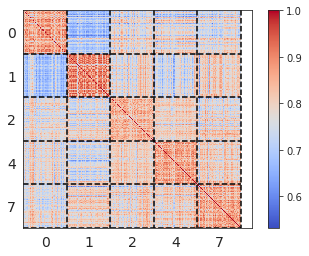

In [16]:
sns.set_style("white")
plt.imshow(all_outputs_corr[:, :, 2], cmap='coolwarm')
plt.colorbar()
plt.xticks([int((i+0.5) * perclass) for i, _ in enumerate(classes)],
           [str(cls) for cls in classes], fontsize=14
          )
plt.yticks([int((i+0.5) * perclass) for i, _ in enumerate(classes)],
           [str(cls) for cls in classes], fontsize=14
          )
plt.ylim(len(y), 0)


ns = np.cumsum([(y == i).sum() for i in classes])

for n in ns:
    plt.plot([0, len(y)], [n, n], "--k")
for n in ns:
    plt.plot([n, n], [0, len(y)], "--k")

## Saving

In [12]:
np.savez("prior_corrs1e-1",
         all_outputs_corr=all_outputs_corr,
         classes=classes,
         perclass=perclass,
         y=y,
        )